In [6]:
% load_ext autoreload
% autoreload 2
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

np.set_printoptions(threshold=5)  # to limit printing

from vflow import ModuleSet, init_args
from vflow.pipeline import build_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# basic pipeline

/Users/chandan/drive/research/veridical_flow/veridical-flow/vflow/pipeline.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


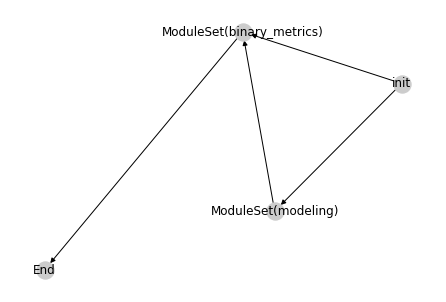

In [11]:
# initialize data
np.random.seed(13)
X, y = sklearn.datasets.make_classification(n_samples=50, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = init_args(
    (X_train, X_test, y_train, y_test),
    names=['X_train', 'X_test', 'y_train', 'y_test']  # optionally name the args
)

# subsample data
subsampling_funcs = [
    partial(sklearn.utils.resample, n_samples=20, random_state=i)
    for i in range(3)
]
subsampling_set = ModuleSet(name='subsampling',
                            modules=subsampling_funcs)
X_trains, y_trains = subsampling_set(X_train, y_train)

# fit models
models = [LogisticRegression(max_iter=1000, tol=0.1), DecisionTreeClassifier()]
modeling_set = ModuleSet(name='modeling',
                         modules=models,
                         module_keys=["LR", "DT"])

modeling_set.fit(X_trains, y_trains)
preds_test = modeling_set.predict(X_test)

# get metrics
binary_metrics_set = ModuleSet(name='binary_metrics',
                               modules=[accuracy_score, balanced_accuracy_score],
                               module_keys=["Acc", "Bal_Acc"])

binary_metrics = binary_metrics_set.evaluate(preds_test, y_test)

G = build_graph(binary_metrics, draw=True)
plt.show()

#inspect the pipeline
# for k1, v1 in hard_metrics.items():
#     print('output', k1)

In [12]:
binary_metrics

{(('X_train', 'y_train', 'subsampling_0', 'LR', 'X_test'),
  'y_test',
  'Acc'): 0.9230769230769231,
 (('X_train', 'y_train', 'subsampling_0', 'LR', 'X_test'),
  'y_test',
  'Bal_Acc'): 0.9444444444444444,
 (('X_train', 'y_train', 'subsampling_0', 'DT', 'X_test'),
  'y_test',
  'Acc'): 0.7692307692307693,
 (('X_train', 'y_train', 'subsampling_0', 'DT', 'X_test'),
  'y_test',
  'Bal_Acc'): 0.7638888888888888,
 (('X_train', 'y_train', 'subsampling_1', 'LR', 'X_test'),
  'y_test',
  'Acc'): 0.9230769230769231,
 (('X_train', 'y_train', 'subsampling_1', 'LR', 'X_test'),
  'y_test',
  'Bal_Acc'): 0.9444444444444444,
 (('X_train', 'y_train', 'subsampling_1', 'DT', 'X_test'),
  'y_test',
  'Acc'): 0.8461538461538461,
 (('X_train', 'y_train', 'subsampling_1', 'DT', 'X_test'),
  'y_test',
  'Bal_Acc'): 0.9,
 (('X_train', 'y_train', 'subsampling_2', 'LR', 'X_test'),
  'y_test',
  'Acc'): 0.8461538461538461,
 (('X_train', 'y_train', 'subsampling_2', 'LR', 'X_test'),
  'y_test',
  'Bal_Acc'): 0.837

# feature engineering pipeline
**this data set predicts boston house-preices dataset (regression)**

../pcsp/pipeline.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


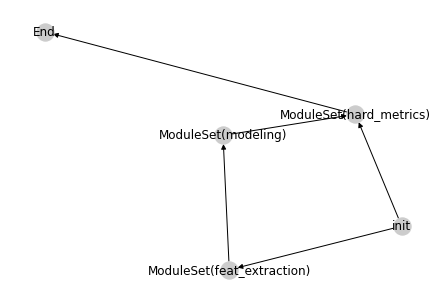

{(((('X_train', 'feat_extraction_0'), 'y_train', 'DT'),
   ('X_train', 'feat_extraction_0')),
  'y_train',
  'r2'): 0.998077138036731,
 (((('X_train', 'feat_extraction_0'), 'y_train', 'RF'),
   ('X_train', 'feat_extraction_0')),
  'y_train',
  'r2'): 0.8543945462831081,
 (((('X_train', 'feat_extraction_1'), 'y_train', 'DT'),
   ('X_train', 'feat_extraction_1')),
  'y_train',
  'r2'): 1.0,
 (((('X_train', 'feat_extraction_1'), 'y_train', 'RF'),
   ('X_train', 'feat_extraction_1')),
  'y_train',
  'r2'): 0.9638279339568567,
 '__prev__': <pcsp.module_set.ModuleSet at 0x7fdc9df45f98>}

In [4]:
# get data as df
np.random.seed(13)
data = sklearn.datasets.load_boston()
df = pd.DataFrame.from_dict(data['data'])
df.columns = data['feature_names']
y = data['target']
X_train, X_test, y_train, y_test = init_args(train_test_split(df, y, random_state=123),
                                             names=['X_train', 'X_test', 'y_train', 'y_test'])


# feature extraction - extracts two different sets of features from the same data
def extract_feats(df: pd.DataFrame, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']):
    '''extract specific columns from dataframe
    '''
    return df[feat_names]


feat_extraction_funcs = [partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']),
                         partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE']),
                         ]
feat_extraction = ModuleSet(name='feat_extraction',
                            modules=feat_extraction_funcs)

X_feats_train = feat_extraction(X_train)
X_feats_test = feat_extraction(X_test)

modeling_set = ModuleSet(name='modeling',
                         modules=[DecisionTreeRegressor(), RandomForestRegressor()],
                         module_keys=["DT", "RF"])

# how can we properly pass a y here so that it will fit properly?
# this runs, but modeling_set.out is empty
_ = modeling_set.fit(X_feats_train, y_train)

# #get predictions
preds_all = modeling_set.predict(X_feats_train)

# y_test_dict = {('data_0', 'feat_extraction_0'): y_test['X_test'], ('data_0', 'feat_extraction_1'): y_test['X_test']}

#get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                             modules=[r2_score],
                             module_keys=["r2"])
hard_metrics = hard_metrics_set.evaluate(preds_all, y_train)

# inspect the pipeline
#for k in hard_metrics:
#     print(k, hard_metrics[k])
G = build_graph(hard_metrics, draw=True)
plt.show()
hard_metrics

In [5]:
X_feats_train.keys()

dict_keys([('X_train', 'feat_extraction_0'), ('X_train', 'feat_extraction_1'), '__prev__'])

In [6]:
X_feats_test.keys()

dict_keys([('X_test', 'feat_extraction_0'), ('X_test', 'feat_extraction_1'), '__prev__'])

In [7]:
for k in preds_all.keys():
    print(k)

((('X_train', 'feat_extraction_0'), 'y_train', 'DT'), ('X_train', 'feat_extraction_0'))
((('X_train', 'feat_extraction_0'), 'y_train', 'RF'), ('X_train', 'feat_extraction_0'))
((('X_train', 'feat_extraction_1'), 'y_train', 'DT'), ('X_train', 'feat_extraction_1'))
((('X_train', 'feat_extraction_1'), 'y_train', 'RF'), ('X_train', 'feat_extraction_1'))
__prev__


In [8]:
len(hard_metrics)

5